<div style='background-image: url("https://tinyurl.com/587zdbkm/title01.png") ; padding: 0px ; background-size: cover ; border-radius: 5px ; height: 250px'>
    <div style="float: right ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.7) ; width: 50% ; height: 150px">
        <div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.8) ; line-height: 100%">Computational Seismology</div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)">Discontinuous Galerkin Method - 1D Elastic Wave Equation, Heterogeneous case</div>
        </div>
    </div>
</div>

## Exercise
* Compare Euler and Runge-Kutta schemes as a function of frequency content and CFL Limit
* Determine CFL Limit for specific model
* Play with model heterogeneity and source location



## Basic Equations

The source-free elastic wave equation in 1D reads 

\begin{align}
\partial_t \sigma - \mu \partial_x v & = 0 \\ 
\partial_t v - \frac{1}{\rho} \partial_x \sigma & = 0
\end{align}

with $\rho$ the density and $\mu$ the shear modulus. This equation in matrix-vector notation follows

\begin{equation}
\partial_t \mathbf{Q} + \mathbf{A} \partial_x \mathbf{Q} = 0
\end{equation}

where $\mathbf{Q} = (\sigma, v)$ is the vector of unknowns and the matrix $\mathbf{A}$ contains the parameters $\rho$ and $\mu$. We seek to solve the linear advection equation as a hyperbolic equation $ \partial_t u + \mu \ \partial_x u=0$. A series of steps need to be done:

1) The weak form of the equation is derived by multiplying both sides by an arbitrary test function. 

2) Apply the stress Free Boundary Condition after integration by parts

3) We approximate the unknown field $\mathbf{Q}(x,t)$ by a sum over space-dependent basis functions $\ell_i$ weighted by time-dependent coefficients $\mathbf{Q}(x_i,t)$, as we did in the spectral elements method. As interpolating functions we choose the Lagrange polynomials and use $\xi$ as the space variable representing the elemental domain:

\begin{equation}
\mathbf{Q}(\xi,t) \ = \ \sum_{i=1}^{N_p} \mathbf{Q}(\xi_i,t) \ell_i(\xi) \qquad with \qquad \ell_i^{(N)} (\xi) \ := \ \prod_{j = 1, \ j \neq i}^{N+1} \frac{\xi - \xi_j}{\xi_i-\xi_j}, \quad i,j = 1, 2, \dotsc , N + 1 
\end{equation}

4) The continuous weak form is written as a system of linear equations by considering the approximated displacement field. Finally, the semi-discrete scheme can be written in matrix-vector form as

\begin{equation}
\mathbf{M}\partial_t \mathbf{Q} = \mathbf{A}\mathbf{K}\mathbf{Q} - \mathbf{Flux}
\end{equation}

5) Time extrapolation is done after applying a standard 1st order finite-difference approximation to the time derivative, we call it the Euler scheme.

\begin{equation}
\mathbf{Q}^{t+1} \approx \mathbf{Q}^{t} + dt\mathbf{M}^{-1}(\mathbf{A}\mathbf{K}\mathbf{Q} - \mathbf{Flux})
\end{equation}

This notebook implements both Euler and Runge-Kutta schemes for solving the free source version of the elastic wave equation in a homogeneous media. To keep the problem simple, we use as spatial initial condition a Gauss function with half-width $\sigma$

\begin{equation}
Q(x,t=0)  = e^{-1/\sigma^2 (x - x_{o})^2}
\end{equation}

In [1]:
# Import all necessary libraries, this is a configuration step for the exercise.
# Please run it before the simulation code!
import numpy as np
import matplotlib
%matplotlib ipympl
# Show Plot in The Notebook
import matplotlib.pyplot as plt

from gll import gll
from lagrange1st import lagrange1st
from flux_hetero import flux

### 1. Initialization of setup

In [6]:
# Initialization of setup
# --------------------------------------------------------------------------
tmax   = 0.6          # Length of seismogram [s]
xmax   = 10000        # Length of domain [m]
vs0    = 2500         # Advection velocity
rho0   = 2500         # Density [kg/m^3]
mu0    = rho0*vs0**2  # shear modulus
N      = 2            # Order of Lagrange polynomials
ne     = 200          # Number of elements
sig    = 100          # width of Gaussian initial condition
x0     = 4000         # x locartion of Gauss
eps    = 0.2          # Courant criterion
iplot  = 20           # Plotting frequency
imethod = 'RK'        # 'Euler', 'RK'

nx = ne*N + 1
dx = xmax/(nx-1)      # space increment
#--------------------------------------------------------------------

# Initialization of GLL points integration weights
[xi,w] = gll(N)     # xi, N+1 coordinates [-1 1] of GLL points
                    # w Integration weights at GLL locations
# Space domain
le = xmax/ne       # Length of elements, here equidistent
ng = ne*N + 1

# Vector with GLL points
k = 0
xg = np.zeros((N+1)*ne)
for i in range(0, ne):
    for j in range(0, N+1):
        k += 1
        xg[k-1] = i*le + .5*(xi[j] + 1)*le

x = np.reshape(xg, (N+1, ne), order='F').T

# Calculation of time step acoording to Courant criterion
dxmin = np.min(np.diff(xg[1:N+1]))
dt = eps*dxmin/vs0 # Global time step
nt = int(np.floor(tmax/dt))

# Mapping - Jacobian
J = le/2  # Jacobian
Ji = 1/J  # Inverse Jacobian

# 1st derivative of Lagrange polynomials
l1d = lagrange1st(N)

### 2. Elemental Mass and Stiffness matrices

The mass and the stiffness matrix are calculated prior time extrapolation, so they are pre-calculated and stored at the beginning of the code. 

The integrals defined in the mass and stiffness matrices are computed using a numerical quadrature, in this cases the GLL quadrature that uses the GLL points and their corresponding weights to approximate the integrals. Hence,

\begin{equation}
M_{ij}^k=\int_{-1}^1 \ell_i^k(\xi)  \ell_j^k(\xi) \ J \ d\xi = \sum_{m=1}^{N_p} w_m \ \ell_i^k (x_m)  \ell_j^k(x_m)\ J =\sum_{m=1}^{N_p} w_m \delta_{im}\ \delta_{jm} \ J= \begin{cases} w_i \ J \ \ \text{ if } i=j \\ 0 \ \ \ \ \ \ \ \text{   if } i \neq j\end{cases}
\end{equation}

that is a **diagonal mass matrix!**. Subsequently, the stiffness matrices is given as 
 
\begin{equation} 
K_{i,j}= \int_{-1}^1 \ell_i^k(\xi) \cdot \partial _x  \ell_j^k(\xi) \ d\xi= \sum_{m=1}^{N_p} w_m \ \ell_i^k(x_m)\cdot \partial_x \ell_j^k(x_m)= \sum_{m=1}^{N_p} w_m \delta_{im}\cdot \partial_x\ell_j^k(x_m)= w_i \cdot \partial_x \ell_j^k(x_i) 
\end{equation}

The Lagrange polynomials and their properties have been already used, they determine the integration weights $w_i$ that are returned by the python method "gll". Additionally, the fist derivatives of such basis, $\partial_x \ell_j^k(x_i)$, are needed, the python method "Lagrange1st" returns them.

In [7]:
# Initialization of system matrices
# -----------------------------------------------------------------
# Elemental Mass matrix
M = np.zeros((N+1, N+1))
for i in range(0, N+1):
    M[i, i] = w[i] * J

# Inverse matrix of M (M is diagonal!)
Minv = np.identity(N+1)
for i in range(0, N+1):
    Minv[i,i] = 1. / M[i,i]

# Elemental Stiffness Matrix
K = np.zeros((N+1, N+1))
for i in range(0, N+1):
    for j in range(0, N+1):
            K[i,j] = w[j] * l1d[i,j] # NxN matrix for every element


### 3. Flux Matrices

The main difference in the heterogeneous case with respect the homogeneous one is found in the definition of fluxes. As in the case of finite volumes when we solve the 1D elastic wave equation, we allow the coefficients of matrix A to vary inside the element.

\begin{equation} 
\mathbf{A}=
     \begin{pmatrix}
       0 & -\mu_i \\
       -1/\rho_i & 0 
     \end{pmatrix}
\end{equation}

Now we need to diagonalize $\mathbf{A}$. Introducing the seismic impedance $Z_i = \rho_i c_i$, we have
 
\begin{equation}
\mathbf{A} = \mathbf{R}^{-1}\mathbf{\Lambda}\mathbf{R}
\qquad\text{,}\qquad
\mathbf{\Lambda}=
     \begin{pmatrix}
       -c_i & 0 \\
        0 & c_i 
     \end{pmatrix}
\qquad\text{,}\qquad
\mathbf{R} =  
     \begin{pmatrix}
       Z_i & -Z_i \\
       1 &  1 
     \end{pmatrix}
\qquad\text{and}\qquad
\mathbf{R}^{-1} = \frac{1}{2Z_i}
     \begin{pmatrix}
       1 & Z_i \\
      -1 & Z_i 
     \end{pmatrix}
\end{equation}

We decompose the solution into right propagating $\mathbf{\Lambda}^{+}$ and left propagating eigenvalues $\mathbf{\Lambda}^{-}$ where

\begin{equation}
\mathbf{\Lambda}^{+}=
     \begin{pmatrix}
       -c_i & 0 \\
        0 & 0 
     \end{pmatrix}
\qquad\text{,}\qquad
\mathbf{\Lambda}^{-}=
     \begin{pmatrix}
        0 & 0 \\
        0 & c_i 
     \end{pmatrix}
\qquad\text{and}\qquad
\mathbf{A}^{\pm} = \mathbf{R}^{-1}\mathbf{\Lambda}^{\pm}\mathbf{R}
\end{equation}

This strategy allows us to formulate the Flux term in the discontinuous Galerkin method. The following cell initializes all flux related matrices

In [8]:
# Inialize Flux relates matrices
# ---------------------------------------------------------------

# initialize heterogeneous A
Ap  = np.zeros((ne,2,2))
Am  = np.zeros((ne,2,2))
Z   = np.zeros(ne)
rho = np.zeros(ne)
mu  = np.zeros(ne)

# initialize c, rho, mu, and Z
rho = rho + rho0
rho[int(ne/2):ne] = .25 * rho[int(ne/2):ne] # Introduce discontinuity 
mu = mu + mu0
c = np.sqrt(mu/rho)
Z = rho * c

# Initialize flux matrices
for i in range(1,ne-1):
    # Left side positive direction
    R = np.array([[Z[i], -Z[i]], [1, 1]])
    Lp = np.array([[0, 0], [0, c[i]]])
    Ap[i,:,:] = R @ Lp @ np.linalg.inv(R)

    # Right side negative direction
    R = np.array([[Z[i], -Z[i]], [1, 1]])
    Lm = np.array([[-c[i], 0 ], [0, 0]])
    Am[i,:,:] = R @ Lm @ np.linalg.inv(R)

### 4. Discontinuous Galerkin Solution

The principal characteristic of the discontinuous Galerkin Method is the communication between the element neighbors using a flux term, in general it is given 

\begin{equation}
\mathbf{Flux} = \int_{\partial D_k} \mathbf{A}\mathbf{Q}\ell_j(\xi)\mathbf{n}d\xi
\end{equation}

this term leads to four flux contributions for left and right sides of the elements

\begin{equation}
\mathbf{Flux} = -\mathbf{A}_{k}^{-}\mathbf{Q}_{l}^{k}\mathbf{F}^{l} + \mathbf{A}_{k}^{+}\mathbf{Q}_{r}^{k}\mathbf{F}^{r} - \mathbf{A}_{k}^{+}\mathbf{Q}_{r}^{k-1}\mathbf{F}^{l} + \mathbf{A}_{k}^{-}\mathbf{Q}_{l}^{k+1}\mathbf{F}^{r}
\end{equation}



Last but not least, we have to solve our semi-discrete scheme that we derived above using an appropriate time extrapolation, in the code below we implemented two different time extrapolation schemes:

1) **Euler scheme** 

\begin{equation}
\mathbf{Q}^{t+1} \approx \mathbf{Q}^{t} + dt\mathbf{M}^{-1}(\mathbf{A}\mathbf{K}\mathbf{Q} - \mathbf{Flux})
\end{equation}

2) Second-order **Runge-Kutta method** (also called predictor-corrector scheme) 

\begin{eqnarray*} 
k_1 &=& f(t_i, y_i) \\
k_2 &=& f(t_i + dt, y_i + dt k_1) \\
& & \\
y_{i+1} &=& y_i + \frac{dt}{2} (k_1 + k_2)
\end{eqnarray*}

with $f$ that corresponds with $\mathbf{M}^{-1}(\mathbf{A}\mathbf{K}\mathbf{Q} - \mathbf{Flux})$

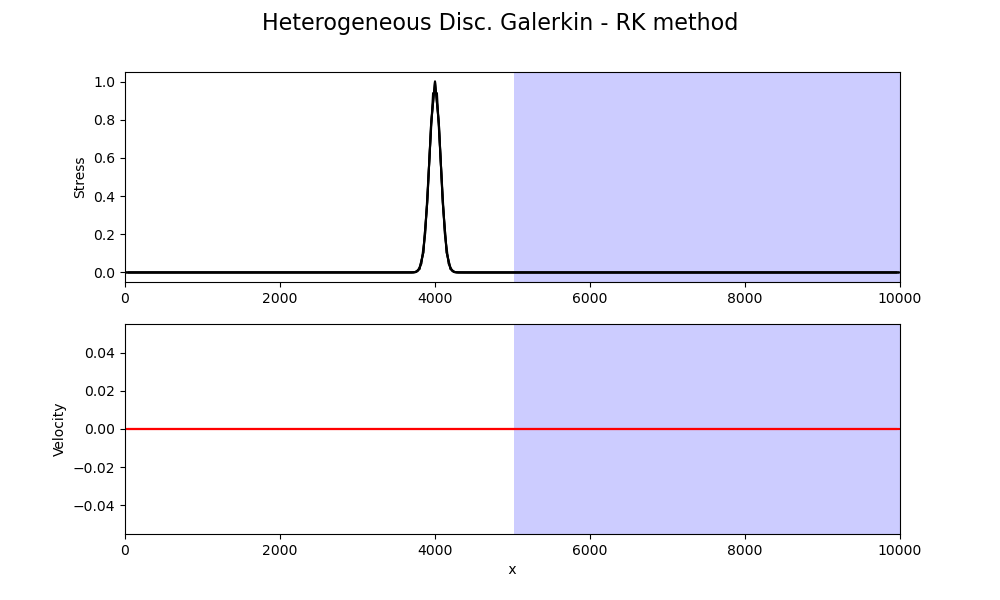

In [9]:
# DG Solution, Time extrapolation
# ---------------------------------------------------------------

# Initalize solution vectors
Q    = np.zeros((ne, N+1, 2))
Qnew = np.zeros((ne, N+1, 2))

k1 = np.zeros((ne, N+1, 2))
k2 = np.zeros((ne, N+1, 2))

Q[:,:,0] = np.exp(-1/sig**2*((x-x0))**2)
Qs = np.zeros(xg.size)  # for plotting
Qv = np.zeros(xg.size)  # for plotting

# Initialize animated plot
# ---------------------------------------------------------------
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
line1 = ax1.plot(x, Q[:,:,0], 'k', lw=1.5)
line2 = ax2.plot(x, Q[:,:,1], 'r', lw=1.5)
ax1.axvspan(((nx-1)/2+1)*dx, nx*dx, alpha=0.2, facecolor='b')
ax2.axvspan(((nx-1)/2+1)*dx, nx*dx, alpha=0.2, facecolor='b')
ax1.set_xlim([0, xmax])
ax2.set_xlim([0, xmax])

ax1.set_ylabel('Stress')
ax2.set_ylabel('Velocity')
ax2.set_xlabel(' x ')
plt.suptitle('Heterogeneous Disc. Galerkin - %s method'%imethod, size=16)

plt.ion() # set interective mode
plt.show()

# ---------------------------------------------------------------
# Time extrapolation
# ---------------------------------------------------------------

for it in range(nt):
    if imethod == 'Euler':
        # Calculate Fluxes
        Flux = flux(Q, N, ne, Ap, Am)
        for i in range(1,ne-1):
            Qnew[i,:,0] = dt * Minv @ (-mu[i] * K @ Q[i,:,1].T - Flux[i,:,0].T) + Q[i,:,0].T
            Qnew[i,:,1] = dt * Minv @ (-1/rho[i] * K @ Q[i,:,0].T - Flux[i,:,1].T) + Q[i,:,1].T
    
    elif imethod == 'RK':
        # Calculate Fluxes
        Flux = flux(Q, N, ne, Ap, Am)
        for i in range(1,ne-1):
            k1[i,:,0] = Minv @ (-mu[i] * K @ Q[i,:,1].T - Flux[i,:,0].T)
            k1[i,:,1] = Minv @ (-1/rho[i] * K @ Q[i,:,0].T - Flux[i,:,1].T)

        for i in range(1,ne-1):
            Qnew[i,:,0] = dt * Minv @ (-mu[i] * K @ Q[i,:,1].T - Flux[i,:,0].T) + Q[i,:,0].T
            Qnew[i,:,1] = dt * Minv @ (-1/rho[i] * K @ Q[i,:,0].T - Flux[i,:,1].T) + Q[i,:,1].T

        Flux = flux(Qnew,N,ne,Ap,Am)
        
        for i in range(1,ne-1):
            k2[i,:,0] = Minv @ (-mu[i] * K @ Qnew[i,:,1].T - Flux[i,:,0].T)
            k2[i,:,1] = Minv @ (-1/rho[i] * K @ Qnew[i,:,0].T - Flux[i,:,1].T)
            
        # Extrapolate
        Qnew = Q + 0.5 * dt * (k1 + k2)

    else:
        raise NotImplementedError

    Q, Qnew = Qnew, Q


    # --------------------------------------   
    # Animation plot. Display solution  
    if not it % iplot:
        for l in line1:
            l.remove()
            del l
        for l in line2:
            l.remove()
            del l

        # stretch for plotting
        k = 0
        for i in range(ne):
            for j in range(N+1):
                Qs[k] = Q[i,j,0]
                Qv[k] = Q[i,j,1]
                k = k + 1
        # -------------------------------------- 
        # Display lines
        line1 = ax1.plot(xg, Qs, 'k', lw=1.5)
        line2 = ax2.plot(xg, Qv, 'r', lw=1.5)
        plt.gcf().canvas.draw()


